In [20]:
import logging
import sys
from io import open
from os import path
from time import time
from glob import glob
from gensim.models import Word2Vec
from six.moves import range, zip, zip_longest
from six import iterkeys
from collections import defaultdict, Iterable
import random
from random import shuffle
from itertools import product, permutations
from scipy.io import loadmat
from scipy.sparse import issparse
from io import open
import deepwalk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn_extra.cluster import KMedoids

In [21]:
# インプットするファイル名
INPUT = nx.karate_club_graph()

# アウトプットするファイル名
OUTPUT = "karate.txt"
# １ノードあたりに実行するウォーク数
NUMBER_WALKS = 10

# 1ウォークあたりの長さ
WALK_LENGTH = 20

# ランダムシード値
SEED = 0

# 埋め込み後の各ノードの次元数
REPRESENTATION_SIZE = 2

# skipgramので使われるウィンドウサイズ
WINDOW_SIZE = 5

# 並列プロセス数
WORKERS = 1

#クラスタ数
N_CLUSTER = 2


In [22]:
"""
    グラフ生成
    G = load_edgelist(ファイル名:String, 無効グラフかどうか:boolean)
    """
G = deepwalk.from_networkx(INPUT, True)
# ノード数出力
print("Number of nodes: {}".format(len(G.nodes())))

# ウォーク数算出(ノード数*1ノードあたりのウォーク数)と出力
num_walks = len(G.nodes()) * NUMBER_WALKS
print("Number of walks: {}".format(num_walks))

# データサイズ(ウォーク数*ウォークの長さ)の算出と出力
data_size = num_walks * WALK_LENGTH
print("Data size (walks*length): {}".format(data_size))

print("Walking Now!!!!!!")

# ウォーク取得(長さは全部等しい)
walks = deepwalk.build_deepwalk_corpus(G, num_paths=NUMBER_WALKS,
                              path_length=WALK_LENGTH, alpha=0, rand=random.Random())

print("Embedding Now!!!!!")
model = Word2Vec(walks, size=REPRESENTATION_SIZE,
                 window=WINDOW_SIZE, min_count=0, sg=1, hs=1, workers=WORKERS)

model.wv.save_word2vec_format(OUTPUT)

#全ベクトルを取得
vec = model.wv.__getitem__([str(i) for i in range(len(G))])

df = pd.DataFrame(data=vec)


Number of nodes: 34
Number of walks: 340
Data size (walks*length): 6800
Walking Now!!!!!!
Embedding Now!!!!!


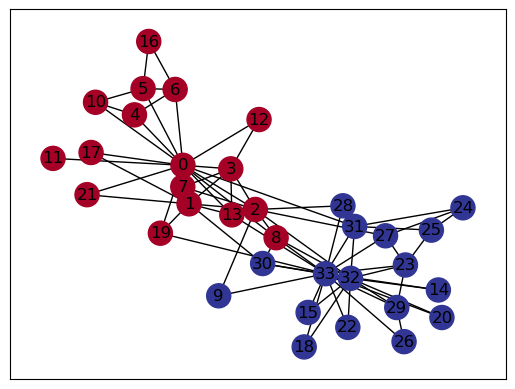

元のネットワークデータ


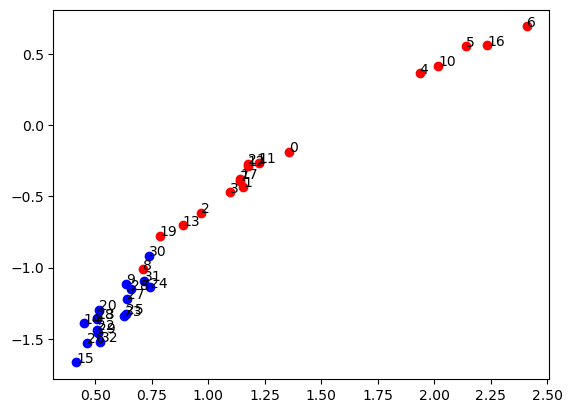

埋め込み後
クラスタリング結果


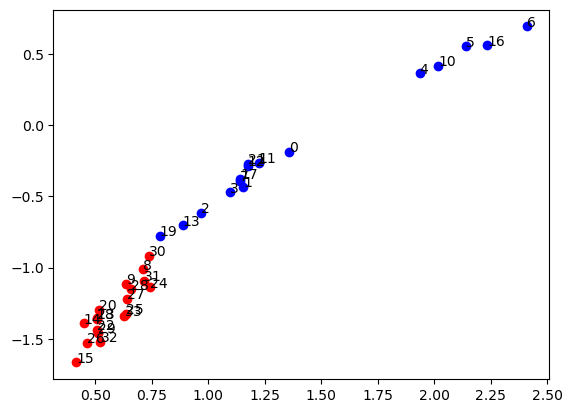

In [23]:
label_true = deepwalk.draw_karateclub(INPUT)
print("元のネットワークデータ")

deepwalk.draw_embedded_vector(INPUT,model.wv)
print("埋め込み後")

pred = KMedoids(n_clusters=N_CLUSTER,random_state=0).fit_predict(vec)
df["cluster_id"] = pred
deepwalk.draw_cluseter(INPUT,model.wv,pred)
print("クラスタリング結果")

In [24]:
adjusted_rand_score(label_true, pred)


0.8822575413558222

In [25]:
name ="deepwalk_"+str(N_CLUSTER)+".txt"
with open(name, 'w') as f:
    for i in range(len(pred)):
        if i+1 == len(pred):
            f.write(str(pred[i]))
        else:
            f.write(str(pred[i])+',')
